In [11]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [12]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

# Prediction Import

In [13]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
df = pd.read_csv('predict.csv', index_col=0)
predict = df.drop('true', axis=1)
true = df['true']
del df
true_encoded = true.map(lambda x: LABELS[x])
true_encoded.name = 'true_label'
predict.columns = LABELS
predict.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking
0,7.008645,-4.870894,-7.724318,-6.329746,-1.225490,6.131849
1,-1.049868,-4.048782,11.256765,1.243060,-1.798530,-1.738715
2,2.179596,-8.300875,-5.747210,-7.787839,7.303552,-0.261810
3,1.642121,9.191607,-4.343593,-7.786537,-4.536829,0.239395
4,-2.033002,-5.243496,1.802455,12.571066,-3.861592,1.792740


In [14]:
# min-max normalization
predict = predict.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
predict = predict.apply(lambda x: x / x.sum(), axis=1)

predict_label = predict.idxmax(axis=1)
predict_probability = predict.max(axis=1)
predict_probability.name = 'predict_probability'
predict_label.name = 'predict_label'
# predict.head()
# true.head()
# true_encoded.head()

In [15]:
df = pd.concat([
            predict,
            predict_probability,
            true,
            predict_label,
            true_encoded
        ], axis=1)
df.head(10)

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,true,predict_label,true_label
0,0.374542,0.072540,0.000000,0.035453,0.165213,0.352252,0.374542,5,Downstairs,Walking
1,0.106508,0.000000,0.543586,0.187943,0.079919,0.082043,0.543586,2,Sitting,Sitting
2,0.281804,0.000000,0.068664,0.013795,0.419579,0.216158,0.419579,4,Upstairs,Upstairs
3,0.229266,0.412839,0.083718,0.000000,0.079020,0.195158,0.412839,1,Jogging,Jogging
4,0.087985,0.000000,0.193097,0.488215,0.037872,0.192831,0.488215,3,Standing,Standing
5,0.132876,0.140965,0.000000,0.076638,0.168095,0.481427,0.481427,5,Walking,Walking
6,0.358895,0.000000,0.082744,0.112544,0.243736,0.202082,0.358895,0,Downstairs,Downstairs
7,0.368399,0.000000,0.089281,0.152285,0.226770,0.163266,0.368399,0,Downstairs,Downstairs
8,0.055674,0.507491,0.049228,0.099130,0.000000,0.288476,0.507491,1,Jogging,Jogging
9,0.242049,0.121023,0.000000,0.045334,0.136033,0.455561,0.455561,5,Walking,Walking


Accuracy:  0.9524098579579944


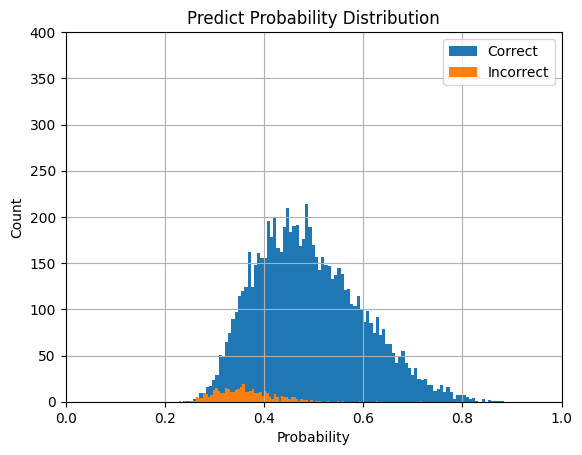

In [16]:
print('Accuracy: ', calc_accuracy(df))
# statival analysis
df.loc[df.true_label==df.predict_label, 'predict_probability'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability'].hist(bins=100)
plt.title('Predict Probability Distribution')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [17]:
df['predict_probability'].agg(['mean', 'std', 'min', 'max', 'median'])

mean      0.484686
std       0.107809
min       0.228236
max       0.883830
median    0.473251
Name: predict_probability, dtype: float64

In [18]:
thresholds = [0, 0.3, 0.4, 0.5, 0.6, 0.7]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
    # cm = confusion_matrix(df_confidence['true_label'], df_confidence['predict_label'])
    # cm_df = pd.DataFrame(cm, index=LABELS, columns=LABELS)
    # plt.figure(figsize=(10, 10))
    # sns.heatmap(
    #     cm_df,
    #     annot=True,
    #     fmt="d",
    #     linewidths=0.5,
    #     cmap="Blues",
    #     cbar=False,
    #     annot_kws={"size": 14},
    #     square=True,
    # )
    # plt.title(f"Confusion Matrix (threshold={threshold})")
    # plt.ylabel("True label")
    # plt.xlabel("Predicted label")
    # plt.savefig(f'confusion_matrix/threshold{threshold}.png')
    # plt.close()
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_10811/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.0,0.952410,1.000000,0.000000,0.000000
0.3,0.958776,0.983611,0.570370,0.016389
0.4,0.985315,0.760592,0.847870,0.239408
0.5,0.997302,0.405002,0.921853,0.594998
0.6,0.998446,0.156246,0.943885,0.843754
0.7,0.996516,0.034843,0.950818,0.965157


/home/nakagawaren/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


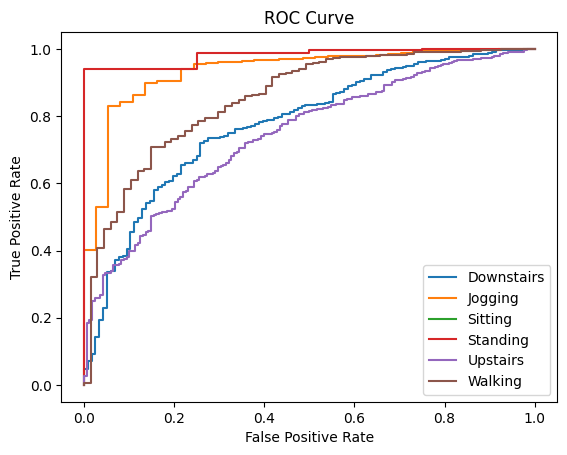

In [19]:
from sklearn.metrics import roc_curve

for label in LABELS:
    fpr, tpr, thresholds = roc_curve(df.loc[df.predict_label==label, 'true_label'], df.loc[df.predict_label==label, "predict_probability"], pos_label=label)
    plt.plot(fpr, tpr, label=label)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Each Label Prediction Probability of histgram

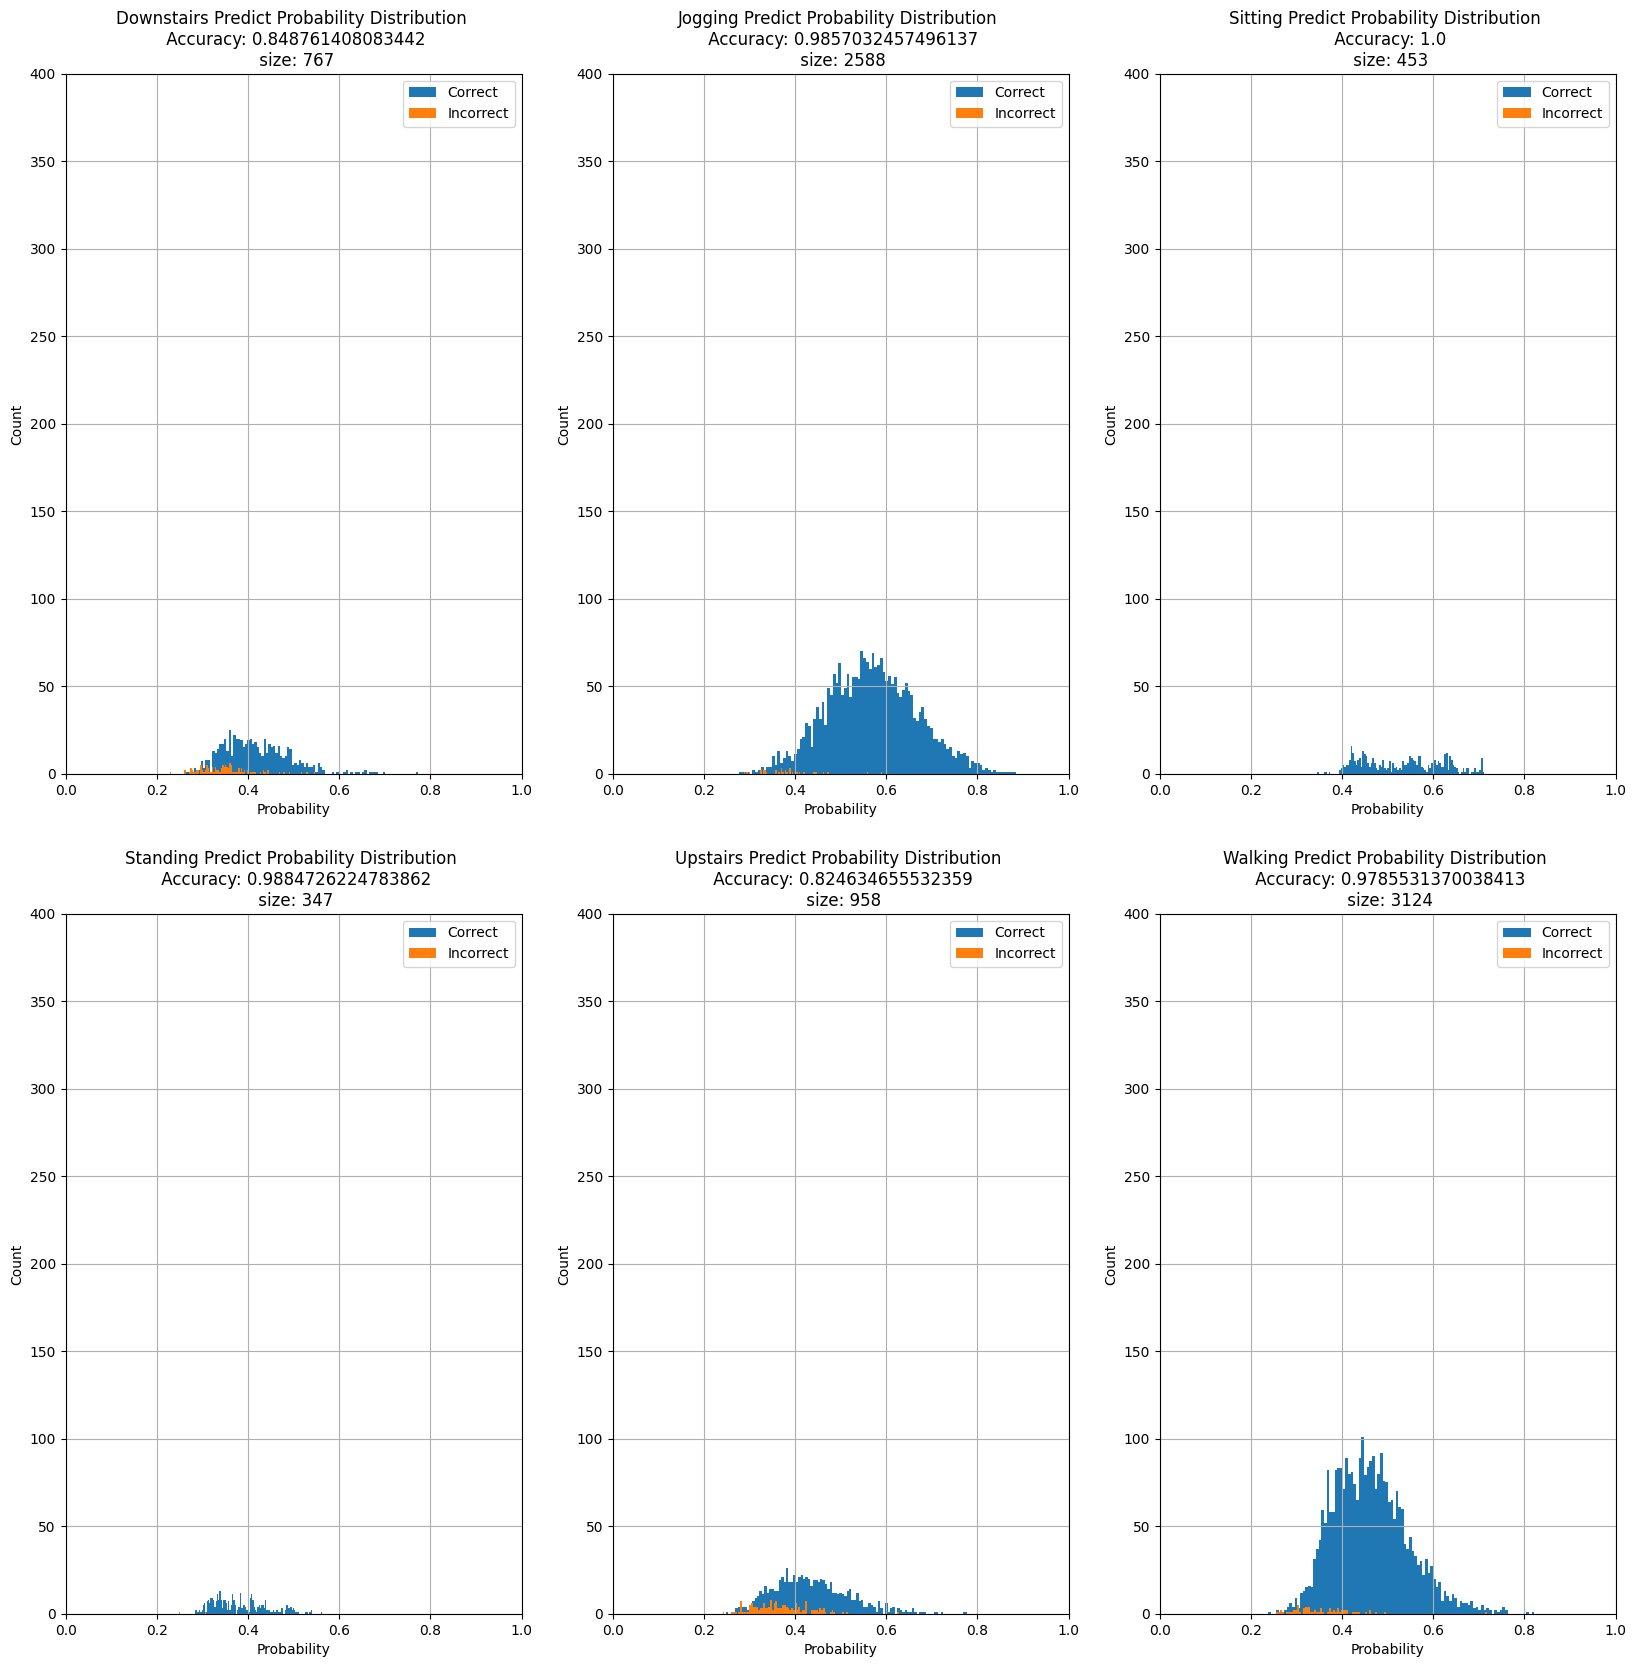

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(20, 20))

for i, label in enumerate(LABELS):
    df_label = df.loc[df.predict_label==label, :]
    df_label.loc[df_label.true_label==df_label.predict_label, 'predict_probability'].hist(bins=100, ax=axs[i//3][i%3])
    df_label.loc[df_label.true_label!=df_label.predict_label, 'predict_probability'].hist(bins=100, ax=axs[i//3][i%3])
    axs[i//3][i%3].set_title(f"{label} Predict Probability Distribution \n Accuracy: {calc_accuracy(df_label)}\n size: {len(df_label)}")
    axs[i//3][i%3].set_xlim(0, 1)
    axs[i//3][i%3].set_ylim(0, 400)
    axs[i//3][i%3].set_xlabel('Probability')
    axs[i//3][i%3].set_ylabel('Count')
    axs[i//3][i%3].legend(['Correct', 'Incorrect'])
# plt.tight_layout()
plt.show()